## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [193]:
# General Data Wrangling
import pandas as pd
import numpy as np
import math
from datetime import date, timedelta
import datetime as dt
from scipy import stats
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# Data preprocessing
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
                                    cross_validate, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy import interp
from itertools import cycle

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Trees
from sklearn.tree import DecisionTreeClassifier 
from IPython.display import Image  

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree

# Support Vector Methods
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_auc_score, roc_curve, auc, plot_roc_curve

from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

import graphviz

In [2]:
pd.set_option('display.max_columns', 600)

## <font color=blue>Data Load<font/>

### Load data:

In [3]:
h1 = pd.read_csv('H1_clean.csv')

### Preview data:

In [4]:
h1.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned,StaysInNights
0,0,7,2015,7,27,1,0,1,1,0,0,BB,NonPortugal,Direct,Direct,0,0,A,C,0,No Deposit,Unknown,Unknown,0,Transient,75.0,0,0,0,1
1,0,13,2015,7,27,1,0,1,1,0,0,BB,NonPortugal,Corporate,Corporate,0,0,A,A,0,No Deposit,Other,Unknown,0,Transient,75.0,0,0,1,1
2,0,14,2015,7,27,1,0,2,2,0,0,BB,NonPortugal,Online TA,TA/TO,0,0,A,A,0,No Deposit,240,Unknown,0,Transient,98.0,0,1,1,2
3,0,14,2015,7,27,1,0,2,2,0,0,BB,NonPortugal,Online TA,TA/TO,0,0,A,A,0,No Deposit,240,Unknown,0,Transient,98.0,0,1,1,2
4,0,0,2015,7,27,1,0,2,2,0,0,BB,Portugal,Direct,Direct,0,0,C,C,0,No Deposit,Unknown,Unknown,0,Transient,107.0,0,0,1,2


The data has been cleaned previously, dealing with outlier, duplication and missing value issues <br>
(cleaning code can be found in the jupyter notebook: **01_datacleaning.ipynb**)

## <font color=blue>Exploratory Data Analysis</font>

Another round of exploratory analysis will be performed for the purpose of feature engineering (deriving other potentially useful features)

In [5]:
h1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39453 entries, 0 to 39452
Data columns (total 30 columns):
IsCanceled                     39453 non-null int64
LeadTime                       39453 non-null int64
ArrivalDateYear                39453 non-null int64
ArrivalDateMonth               39453 non-null int64
ArrivalDateWeekNumber          39453 non-null int64
ArrivalDateDayOfMonth          39453 non-null int64
StaysInWeekendNights           39453 non-null int64
StaysInWeekNights              39453 non-null int64
Adults                         39453 non-null int64
Children                       39453 non-null int64
Babies                         39453 non-null int64
Meal                           39453 non-null object
Country                        39453 non-null object
MarketSegment                  39453 non-null object
DistributionChannel            39453 non-null object
IsRepeatedGuest                39453 non-null int64
PreviousBookingsNotCanceled    39453 non-null int64
Res

In [6]:
def cont_cols(df):
    """For a given DataFrame: identify all columns that hold numeric data (with 15+ unique values)"""
    return ([col for col in df.columns if df[col].dtype in ['float64', 'int64'] and df[col].nunique() > 15])

def cat_cols(df):
    """For a given DataFrame: identify all columns that hold 15 or fewer unique values"""   
    return ([col for col in df.columns if df[col].nunique() <= 15])

In [7]:
cont_cols(h1)

['LeadTime',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'PreviousBookingsNotCanceled',
 'DaysInWaitingList',
 'ADR',
 'StaysInNights']

In [8]:
def plot_dists(df, var_type = None, target = None):
    """ for a specified DataFrame state whether you want to plot continuous variables by passing 
        the argument: 'continuous' if so then the function will plot a distribution plot for each 
        numeric variable or a boxplot depending on whether you specify a target variable
        
        If var_type = None then the function will plot a barplot or a stacked barplot
        depending on whether you specify a target variable        
        """
    if var_type == 'continuous':
    
        numeric_columns = cont_cols(df)
    
        numeric_columns_count = len(numeric_columns)

        shape_dim = math.ceil(numeric_columns_count/4)
    
        df_cont = df[numeric_columns]
        fig2, axes2 = plt.subplots(shape_dim, 4, figsize = (20,10))
    
        for n in range(0, numeric_columns_count):
    
            i = df_cont.dtypes.index[n]
    
            row = (n)//4
            col = (n)%4
    
            ax = axes2[row][col]
            if target:
                sns.boxplot(x = target, y = i, data = df[numeric_columns + [target]], ax = ax)
                ax.set_title('{}'.format(i))
                plt.subplots_adjust(wspace=0.2, hspace=0.2);
            else:
                sns.kdeplot(df_cont[i], ax = ax)
                ax.set_title('{}'.format(i))
                plt.subplots_adjust(wspace=0.2, hspace=0.2);
            
    else:
        
        cat_columns = cat_cols(df)
    
        cat_columns_count = len(cat_columns)

        shape_dim = math.ceil(cat_columns_count/4)
    
        df_cat = df[cat_columns]

        fig2, axes2 = plt.subplots(shape_dim, 4, figsize = (30,30))
        
    
        for n in range(0, cat_columns_count):
    
            i = df_cat.dtypes.index[n]
            
            row = (n)//4
            col = (n)%4
    
            ax = axes2[row][col]
            if target:
                if i == target:
                    sns.countplot(x = i, data = df_cat, ax = ax)
                    ax.set_title('{}'.format(i))
                    plt.subplots_adjust(wspace=0.2, hspace=0.2);
                else:
                    df_plot = df.groupby([target, i]).size().reset_index().pivot(columns=target, index=i, values=0)
                    df_plot.plot(kind='bar', stacked=True, ax = ax)
                    ax.set_title('{}'.format(i))
                    plt.subplots_adjust(wspace=0.2, hspace=0.2);
            else:
                sns.countplot(x = i, data = df_cat, ax = ax)
                ax.set_title('{}'.format(i))
                plt.subplots_adjust(wspace=0.2, hspace=0.2);

Plot all continuous variables as a distribution curve:

In [200]:
#plot_dists(h1, var_type = 'continuous')

Plot all continuous variables as a box plot against the target variable **`IsCanceled`**:

In [201]:
#plot_dists(h1, var_type = 'continuous', target = 'IsCanceled')

Plot categorical variables:

In [202]:
#plot_dists(h1, var_type = 'categorical')

Plot all stacked bars of categorical variables vs target variable to guage split across the category values:

In [203]:
#plot_dists(h1, var_type = 'categorical', target = 'IsCanceled')

### Derive Variables

#### `day_of_week` and `quarter` derived from `date`

It would be useful to explore whether the time of year (quarter,  Month) or time of week (day) has any impact on the liklihood of a booking being canceled. Therefore the day and quarter will need to be extracted from the **`ArrivalDate`** column.

Month is already available within the data.

In [13]:
h1['ArrivalDateMonth'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [14]:
month_conv = {1: '001_Jan', 2: '002_Feb', 3: '003_Mar', 4: '004_Apr', 
                5: '005_May', 6: '006_Jun', 7: '007_Jul', 8: '008_Aug', 9: '009_Sept', 
                10: '010_Oct', 11: '011_Nov', 12: '012_Dec'}

In [15]:
h1['arrivaldate'] = h1.apply(lambda x: dt.datetime(x['ArrivalDateYear'], x['ArrivalDateMonth'], \
                                                   x['ArrivalDateDayOfMonth']), axis = 1)

In [16]:
h1['ArrivalDateMonth_abbr'] = h1['ArrivalDateMonth'].map(lambda x: month_conv[x])

In [17]:
#   extract the day and quarter from the date variable:

h1['Arrival_day_of_week'] = h1['arrivaldate'].dt.dayofweek
h1['Arrival_quarter'] = h1['arrivaldate'].dt.quarter

In [18]:
h1['Arrival_quarter'].value_counts()

3    12341
2    10113
1     8533
4     8466
Name: Arrival_quarter, dtype: int64

In [19]:
h1['Arrival_day_of_week'].value_counts()

5    7012
0    6242
3    6145
4    5615
6    4893
2    4790
1    4756
Name: Arrival_day_of_week, dtype: int64

do the same for booking date:

In [20]:
# calculate booking date from arrival date and leadtime
h1['Booking_Date'] = h1.apply(lambda x: x['arrivaldate'] - timedelta(x['LeadTime']), axis = 1)

In [204]:
#fig = plt.figure(figsize = (20, 10))
#sns.countplot('Booking_Date', data = h1)

In [22]:
#   Extract the day, month and quarter from the booking_date variable:
h1['Booking_month'] = h1['Booking_Date'].dt.month.map(lambda x: month_conv[x])
h1['Booking_day_of_week'] = h1['Booking_Date'].dt.dayofweek
h1['Booking_quarter'] = h1['Booking_Date'].dt.quarter

In [205]:
# view all categorical variables (including new derived variables):
#plot_dists(h1, var_type = 'categorical')

There is a possible **imbalance** issue with the target variable (3:1 in favour of the negative case):

In [24]:
h1.IsCanceled.value_counts(normalize = True)

0    0.723291
1    0.276709
Name: IsCanceled, dtype: float64

## Modelling

In [25]:
# separate features and target variable
X = h1.drop(['IsCanceled', 'arrivaldate', 'ArrivalDateMonth', 'Booking_Date'],  axis = 1)
y = h1.loc[:, 'IsCanceled']

### Logistic Regression

logistic regression requires categorical variables to be converted to dummy variables via one-hot encoding:


In [26]:
x_dum_logit = pd.get_dummies(X, drop_first=True, dtype=float)

In [27]:
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(x_dum_logit, y, test_size = 0.3, random_state = 42)

In [28]:
# further split train data into train validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [29]:
###################################################################################################################
# FOR DAN TO VERIFY IS THIS CORRECT
# how can I ensure that the splits maintain a similar target variable split.

# should this be done every time?
###################################################################################################################

From henceforth, oversampling will be used for the models built:

In [30]:
# instantiate oversampling algorithm SMOTE
smote = SMOTE()

In [31]:
# Instantiate Kfold
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#### Logistic BASE model:

In [32]:
# instantiate model
logreg = LogisticRegression(fit_intercept = True, C = 1e15, solver='saga', penalty = 'l1', max_iter = 100)

In [33]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('o', smote), \
         ('model', logreg)]

pipeline = Pipeline(steps = steps)

In [34]:
%%time
# Train the model using cross validation and oversampling
logreg_base = cross_validate(pipeline, X_train, y_train, scoring=['accuracy', 'roc_auc'], \
                             cv=crossvalidation, return_train_score = True)

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 17.5 s, sys: 212 ms, total: 17.7 s
Wall time: 16.2 s


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [35]:
# compare train and validation set scores

baseline_accuracy_train = np.mean(logreg_base['train_accuracy'])
baseline_accuracy_validation = np.mean(logreg_base['test_accuracy'])

baseline_AUC_train = np.mean(logreg_base['train_roc_auc'])
baseline_AUC_validation = np.mean(logreg_base['test_roc_auc'])

print('baseline_accuracy_train:', round(baseline_accuracy_train, 4))
print('baseline_accuracy_validation:', round(baseline_accuracy_validation, 4))

print('baseline_AUC_train:', round(baseline_AUC_train, 4))
print('baseline_AUC_validation:' , round(baseline_AUC_validation, 4))

baseline_accuracy_train: 0.6735
baseline_accuracy_validation: 0.673
baseline_AUC_train: 0.7097
baseline_AUC_validation: 0.7085


No evidence of overfitting. <br>
We have achieved mediocre performance of 66% accuracy and 70% AUC (room to improve)

Running the above cross_validate function does not provide any appropriate outputs such that we can plot a ROC curve of our trained model.

We will have to build a manual cross validation loop which will provide the relevant outputs to enable us to build a ROC curve based on the mean results of each Kfold.

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

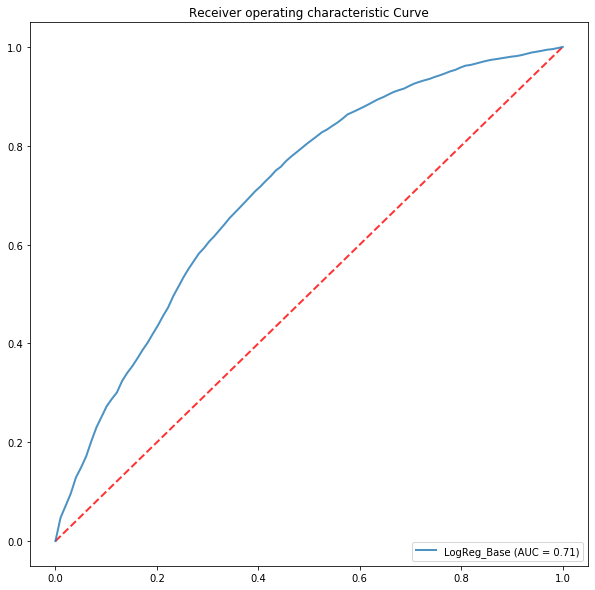

In [36]:
tprs = []
aucs = []
mean_fpr_LogReg_Base = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10, 10))
for i, (train, validation) in enumerate(crossvalidation.split(X_train, y_train)):
    X_train_over, y_train_over = smote.fit_sample(X_train.iloc[train], y_train.iloc[train]) 
    lf = logreg.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train.iloc[validation])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train.iloc[validation], probas_[:, 1])
    interp_tpr = interp(mean_fpr_LogReg_Base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)

mean_tpr_LogReg_Base = np.mean(tprs, axis=0)
mean_tpr_LogReg_Base[-1] = 1.0
mean_auc_LogReg_Base = auc(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base)
std_auc = np.std(aucs)
ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
        label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
        lw=2, alpha=.8)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
ax.legend(loc="lower right")
plt.show()

In [37]:
###################################################################################################################
# FOR DAN TO VERIFY IS THIS CORRECT
# I trained the logreg model in the cross_validation stage 
# for extra reassurance, I fitted the data on the train data as a whole and then applied it top the validation set
# to check results.

# is this an acceptable action?
###################################################################################################################
X_train_over, y_train_over = smote.fit_sample(X_train, y_train) 
lf = logreg.fit(X_train_over, y_train_over)
probas_val = lf.predict_proba(X_val)

fpr, tpr, thresholds = roc_curve(y_val, probas_val[:, 1])
auc(fpr, tpr)

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7189581895256802

The logistic regression base model has yielded mediocre results. We will attempt to improve performance via Hyperparameter tuning:

In [38]:
# Instantiate logistic regression model for tuning:
logreg_gs = LogisticRegression(fit_intercept = True, max_iter = 100)

In [39]:
# define parameters to tune in GridSerachCV
# parameter names need to be prefixed with the same name passed in the pipeline steps i.e. 'classification__'
logreg_param_grid = {"classification__solver": ['saga', 'liblinear'],
                     "classification__penalty": ["l1", "l2"],
                 "classification__C": [0.1, 0.2, 0.3, 0.5, 0.5, 0.8, 1.0, 1e15, 5e15]
                }

In [40]:
# build a pipeline to include the oversampling method in order to pass it to GridSerachCV:

steps = [('sampling', smote), \
         ('classification', logreg_gs)]

pipeline = Pipeline(steps = steps)

In [41]:
# instantiate the using GridSearchCV including the oversampling pipeline
logreg_grid_search = GridSearchCV(pipeline, logreg_param_grid, cv = crossvalidation, return_train_score=True, \
                                scoring = ['accuracy', 'roc_auc'], refit = 'roc_auc')

In [42]:
%%time
# Train the model
logreg_grid_search.fit(X_train, y_train)

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceW

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 24min 11s, sys: 8.92 s, total: 24min 19s
Wall time: 23min 20s


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('classification',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1...
      

In [43]:
# Retrieve the hyperparameters that yielded the best results

logreg_gs_best_params = logreg_grid_search.best_params_


# Retrieve the best results

logreg_gs_training_accuracy =  np.mean(logreg_grid_search.cv_results_['mean_train_accuracy'])
logreg_gs_validation_accuracy =  np.mean(logreg_grid_search.cv_results_['mean_test_accuracy'])

logreg_gs_training_auc =  np.mean(logreg_grid_search.cv_results_['mean_train_roc_auc'])
logreg_gs_validation_auc =  np.mean(logreg_grid_search.cv_results_['mean_test_roc_auc'])

print("Best Parameter Combination Found During Grid Search\n", logreg_gs_best_params)
print(f"Mean Training Accuracy: {logreg_gs_training_accuracy :.2%}")
print(f"Mean Validation Accuracy: {logreg_gs_validation_accuracy :.2%}")
print(f"Mean Training AUC: {logreg_gs_training_auc :.2%}")
print(f"Mean Validation AUC: {logreg_gs_validation_auc :.2%}")

Best Parameter Combination Found During Grid Search
 {'classification__C': 5000000000000000.0, 'classification__penalty': 'l1', 'classification__solver': 'liblinear'}
Mean Training Accuracy: 75.51%
Mean Validation Accuracy: 75.38%
Mean Training AUC: 80.94%
Mean Validation AUC: 80.74%


In [44]:
# For extra confirmation, check whether similar accuracy is achieved when model is applied to the validation set:

logreg_grid_search.score(X_val, y_val)

0.9044467546955061

In [45]:
###################################################################################################################
# FOR DAN TO VERIFY
# accuracy score for the validation set was 83% whereas for the training it was 75%
# is this a problem?
###################################################################################################################

In [206]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

With hyperparameter tuning we improved our logistic regression model by approx. 19%

In [47]:
###################################################################################################################
# FOR DAN TO VERIFY
# auc for LogReg_GridSearch when applied to new data yields 90% AUC whereas during crossvalidation it yielded an average
# of score for the validation set was 83% whereas for the training it was 75%
# is this a problem?
###################################################################################################################

### Decision Tree Classifiers

All other classifier models require categorical variables to be converted to dummy variables BUT without performing one-hot encoding:

In [48]:
X_dum = pd.get_dummies(X)

In [49]:
X_train2 = X_dum.loc[[x for x in list(X_train.index)],:]
y_train2 = y.loc[[x for x in list(y_train.index)]]
X_val2 = X_dum.loc[[x for x in list(X_val.index)],:]
y_val2 = y.loc[[x for x in list(y_val.index)]]
X_test2 = X_dum.loc[[x for x in list(X_test.index)],:]
y_test2 = y.loc[[x for x in list(y_test.index)]]

#### Decision Tree BASE model

In [50]:
# SMOTE and crossvalidation have already been instantiated during the logistic regression stage and can be reused

In [51]:
# instantiate model
tree_clf = DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5)

In [52]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('o', smote), \
         ('model', tree_clf)]

pipeline = Pipeline(steps = steps)

In [53]:
%%time
# Train the tree using cross validation and oversampling
tree_clf_base = cross_validate(pipeline, X_train2, y_train2, scoring=['accuracy', 'roc_auc'], \
                               cv=crossvalidation, return_train_score = True, return_estimator = True)

CPU times: user 2.82 s, sys: 156 ms, total: 2.97 s
Wall time: 2.08 s


In [54]:
tree_clf_base_accuracy_train = np.mean(tree_clf_base['train_accuracy'])
tree_clf_base_accuracy_val = np.mean(tree_clf_base['test_accuracy'])

tree_clf_base_AUC_train = np.mean(tree_clf_base['train_roc_auc'])
tree_clf_base_AUC_val = np.mean(tree_clf_base['test_roc_auc'])


print('baseline_accuracy_train:', round(tree_clf_base_accuracy_train, 4))
print('baseline_accuracy_test:', round(tree_clf_base_accuracy_val, 4))

print('baseline_AUC_train:', round(tree_clf_base_AUC_train, 4))
print('baseline_AUC_test:' , round(tree_clf_base_AUC_val, 4))

baseline_accuracy_train: 0.8406
baseline_accuracy_test: 0.8369
baseline_AUC_train: 0.9044
baseline_AUC_test: 0.9016


In [55]:
tprs = []
aucs = []
mean_fpr_tree_clf_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = tree_clf.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_tree_clf_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))
    
mean_tpr_tree_clf_base = np.mean(tprs, axis=0)
mean_tpr_tree_clf_base[-1] = 1.0
mean_auc_tree_clf_base = auc(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base)
std_auc = np.std(aucs)

In [207]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

The decision tree base model has yielded equal results to our best logistic regression model. We will attempt to improve performance even more via Hyperparameter tuning:

#### Decision Tree GridSearchCV

In [57]:
tree_gs = DecisionTreeClassifier(random_state=10)

In [58]:
tree_param_grid = {"classification__criterion": ["gini", "entropy"],
                 #"classification__max_depth": [None, 2, 3, 4, 5, 6],
                 #"classification__min_samples_split": [2, 5, 10],
                 "classification__min_samples_leaf": [1, 2, 3, 4, 5, 6]}

In [59]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('sampling', smote), \
         ('classification', tree_gs)]

pipeline = Pipeline(steps = steps)

In [60]:
#instantiate tree to pass to gridsearchCV:
tree_grid_search = GridSearchCV(pipeline, tree_param_grid, cv = crossvalidation, return_train_score=True, \
                                scoring = ['accuracy', 'roc_auc'], refit = 'roc_auc')

In [61]:
%%time
# run gridsearchCV
tree_grid_search.fit(X_train2, y_train2)

CPU times: user 48.2 s, sys: 2.16 s, total: 50.4 s
Wall time: 1min 15s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('classification',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nod...
                                              

In [62]:
# Retrieve the hyperparameters that yielded the best results

dt_gs_best_params = tree_grid_search.best_params_


# Retrieve the best results

dt_gs_training_accuracy =  np.mean(tree_grid_search.cv_results_['mean_train_accuracy'])
dt_gs_validation_accuracy =  np.mean(tree_grid_search.cv_results_['mean_test_accuracy'])

dt_gs_training_auc =  np.mean(tree_grid_search.cv_results_['mean_train_roc_auc'])
dt_gs_validation_auc =  np.mean(tree_grid_search.cv_results_['mean_test_roc_auc'])

print("Best Parameter Combination Found During Grid Search\n", dt_gs_best_params)
print(f"Mean Training Accuracy: {dt_gs_training_accuracy :.2%}")
print(f"Mean Validation Accuracy: {dt_gs_validation_accuracy :.2%}")
print(f"Mean Training Score: {dt_gs_training_auc :.2%}")
print(f"Mean Validation Score: {dt_gs_validation_auc :.2%}")

Best Parameter Combination Found During Grid Search
 {'classification__criterion': 'entropy', 'classification__min_samples_leaf': 6}
Mean Training Accuracy: 96.16%
Mean Validation Accuracy: 86.04%
Mean Training Score: 99.36%
Mean Validation Score: 86.96%


##### OVERFIT!!
##### try again hyperparameter tuning

In [63]:
tree_param_grid_2 = {"classification__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [64]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('sampling', smote), \
         ('classification', tree_gs)]

pipeline = Pipeline(steps = steps)

In [65]:
tree_grid_search_2 = GridSearchCV(pipeline, tree_param_grid_2, cv = crossvalidation, return_train_score=True, \
                                  scoring = ['accuracy', 'roc_auc'], refit = 'accuracy')

In [66]:
%%time
tree_grid_search_2.fit(X_train2, y_train2)

CPU times: user 32.8 s, sys: 1.65 s, total: 34.5 s
Wall time: 25.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('classification',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nod...
                                              

In [67]:
# Retrieve the hyperparameters that yielded the best results

dt_gs_2_best_params = tree_grid_search_2.best_params_


# Retrieve the best results

dt_gs_2_training_accuracy =  np.mean(tree_grid_search_2.cv_results_['mean_train_accuracy'])
dt_gs_2_validation_accuracy =  np.mean(tree_grid_search_2.cv_results_['mean_test_accuracy'])

dt_gs_2_training_auc =  np.mean(tree_grid_search_2.cv_results_['mean_train_roc_auc'])
dt_gs_2_validation_auc =  np.mean(tree_grid_search_2.cv_results_['mean_test_roc_auc'])

print("Best Parameter Combination Found During Grid Search\n", dt_gs_2_best_params)
print(f"Mean Training Accuracy: {dt_gs_2_training_accuracy :.2%}")
print(f"Mean Validation Accuracy: {dt_gs_2_validation_accuracy :.2%}")
print(f"Mean Training Score: {dt_gs_2_training_auc :.2%}")
print(f"Mean Validation Score: {dt_gs_2_validation_auc :.2%}")

Best Parameter Combination Found During Grid Search
 {'classification__max_depth': 12}
Mean Training Accuracy: 85.87%
Mean Validation Accuracy: 84.44%
Mean Training Score: 91.57%
Mean Validation Score: 89.81%


**lower performance than the first gridsearch model but this time not overfit**

In [208]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)
# plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
#                          name='Tree_GridSearch',
#                          lw=1, ax=ax)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

In [69]:
###################################################################################################################
# FOR DAN TO VERIFY
# Even though the decision tree gridsearch curve has higher auc does it matter that at certain 
# points it is lower than the other curves (and the weird shape at fpr = 0.02?)
###################################################################################################################

**So far thhis decision tree with tuned parameters has yielded the best auc score**<br>
Will attempt to improve upon it using ensemble methods:

### Ensemble Methods (Decision Tree Classifiers)

In [70]:
###################################################################################################################
# FOR DAN TO VERIFY
# How do we perform oversampling during ensemble methods.
###################################################################################################################

#### Bagged Classifier

In [71]:
# BalancedBaggingClassifier allows for over/under sampling during model build stage

bagged_tree = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy=1.0,
                                replacement=True,
                                random_state=0)

In [72]:
bagged_tree.fit(X_train2, y_train2)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                p

In [73]:
bagged_tree.score(X_train2, y_train2)

0.9540116910661631

In [74]:
bagged_tree.score(X_val2, y_val2)

0.887762490948588

**OVERFIT!!**

#### Random Forest

In [75]:
forest = RandomForestClassifier(max_depth = 5, n_estimators = 100)

In [76]:
steps = [('o', smote), \
         ('model', forest)]

pipeline = Pipeline(steps = steps)

In [77]:
%%time
forest_base = cross_validate(pipeline, X_train2, y_train2, scoring=['accuracy', 'roc_auc'], \
                             cv=crossvalidation, return_train_score = True, return_estimator=True)

CPU times: user 8.67 s, sys: 181 ms, total: 8.85 s
Wall time: 8.01 s


In [78]:
forest_base_accuracy_train = np.mean(forest_base['train_accuracy'])
forest_base_accuracy_validation = np.mean(forest_base['test_accuracy'])

forest_base_AUC_train = np.mean(forest_base['train_roc_auc'])
forest_base_AUC_validation = np.mean(forest_base['test_roc_auc'])

print('forest_base_accuracy_train:', round(forest_base_accuracy_train, 4))
print('forest_base_accuracy_validation:', round(forest_base_accuracy_validation, 4))

print('forest_base_AUC_train:', round(forest_base_AUC_train, 4))
print('forest_base_AUC_validation:' , round(forest_base_AUC_validation, 4))

forest_base_accuracy_train: 0.8529
forest_base_accuracy_validation: 0.8536
forest_base_AUC_train: 0.9192
forest_base_AUC_validation: 0.9161


In [79]:
tprs = []
aucs = []
mean_fpr_forest_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = forest.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train2.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_forest_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

mean_tpr_forest_base = np.mean(tprs, axis=0)
mean_tpr_forest_base[-1] = 1.0
mean_auc_forest_base = auc(mean_fpr_forest_base, mean_tpr_forest_base)
std_auc = np.std(aucs)

In [209]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)
# plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
#                          name='Tree_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_forest_base, mean_tpr_forest_base,
#         label=r'RandomForest (AUC = %0.2f)' % (mean_auc_forest_base),
#         lw=2, alpha=.8)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

The RandomForest model has yielded the strongest results so far. We will attempt to improve performance via Hyperparameter tuning:

In [81]:
rf_clf = RandomForestClassifier()

In [82]:
rf_param_grid = {"classification__n_estimators": [10, 30, 100],
                 "classification__criterion": ["gini", "entropy"],
                 #"classification__max_depth": [None, 2, 6, 10],
                 #"classification__min_samples_split": [5, 10],
                 "classification__min_samples_leaf": [3, 6]}

In [83]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('sampling', smote), \
         ('classification', rf_clf)]

pipeline = Pipeline(steps = steps)

In [84]:
rf_grid_search = GridSearchCV(pipeline, rf_param_grid, cv = crossvalidation, return_train_score=True, \
                              scoring = ['accuracy', 'roc_auc'], refit = 'accuracy')

In [85]:
%%time
rf_grid_search.fit(X_train2, y_train2)

CPU times: user 2min 8s, sys: 2.45 s, total: 2min 10s
Wall time: 2min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('classification',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='a...
                                              

In [86]:
# Retrieve the hyperparameters that yielded the best results

rf_grid_search_best_params = rf_grid_search.best_params_


# Retrieve the best results

rf_grid_search_training_accuracy =  np.mean(rf_grid_search.cv_results_['mean_train_accuracy'])
rf_grid_search_validation_accuracy =  np.mean(rf_grid_search.cv_results_['mean_test_accuracy'])

rf_grid_search_training_auc =  np.mean(rf_grid_search.cv_results_['mean_train_roc_auc'])
rf_grid_search_validation_auc =  np.mean(rf_grid_search.cv_results_['mean_test_roc_auc'])

print("Best Parameter Combination Found During Grid Search\n", rf_grid_search_best_params)
print(f"Mean Training Accuracy: {rf_grid_search_training_accuracy :.2%}")
print(f"Mean Validation Accuracy: {rf_grid_search_validation_accuracy :.2%}")
print(f"Mean Training Score: {rf_grid_search_training_auc :.2%}")
print(f"Mean Validation Score: {rf_grid_search_validation_auc :.2%}")

Best Parameter Combination Found During Grid Search
 {'classification__criterion': 'entropy', 'classification__min_samples_leaf': 3, 'classification__n_estimators': 100}
Mean Training Accuracy: 93.61%
Mean Validation Accuracy: 88.69%
Mean Training Score: 98.38%
Mean Validation Score: 94.61%


##### OVERFIT!!
##### try again hyperparameter tuning

In [87]:
rf_grid_search.score(X_val2, y_val2)
###################################################################################################################
# FOR DAN TO VERIFY
# even though the gridsearch indicated overfitting. when applying the model on new data I recieve similar accuracy 
# score to the validation data within the cross validation stage.
# based on this, is it really overfit?
###################################################################################################################

0.8987448708665219

In [88]:
rf_param_grid_2 = {"classification__n_estimators": [10, 30, 100],
                 "classification__criterion": ["gini", "entropy"],
                 #"classification__max_depth": [None, 2, 6, 10],
                 #"classification__min_samples_split": [5, 10],
                 "classification__min_samples_leaf": [5, 6, 7]}

In [89]:
# build a pipeline to include the oversampling method in order to pass it to the cross validation stage:

steps = [('sampling', smote), \
         ('classification', rf_clf)]

pipeline = Pipeline(steps = steps)

In [90]:
rf_grid_search_2 = GridSearchCV(pipeline, rf_param_grid_2, cv = crossvalidation, return_train_score=True, \
                                scoring = ['accuracy', 'roc_auc'], refit = 'accuracy')

In [91]:
%%time
rf_grid_search_2.fit(X_train2, y_train2)

CPU times: user 3min 17s, sys: 4.28 s, total: 3min 22s
Wall time: 3min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('classification',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='a...
                                              

In [92]:
# Retrieve the hyperparameters that yielded the best results

rf_grid_search_2_best_params = rf_grid_search_2.best_params_


# Retrieve the best results

rf_grid_search_2_training_accuracy =  np.mean(rf_grid_search_2.cv_results_['mean_train_accuracy'])
rf_grid_search_2_validation_accuracy =  np.mean(rf_grid_search_2.cv_results_['mean_test_accuracy'])

rf_grid_search_2_training_auc =  np.mean(rf_grid_search_2.cv_results_['mean_train_roc_auc'])
rf_grid_search_2_validation_auc =  np.mean(rf_grid_search_2.cv_results_['mean_test_roc_auc'])

print("Best Parameter Combination Found During Grid Search\n", rf_grid_search_2_best_params)
print(f"Mean Training Accuracy: {rf_grid_search_2_training_accuracy :.2%}")
print(f"Mean Validation Accuracy: {rf_grid_search_2_validation_accuracy :.2%}")
print(f"Mean Training Score: {rf_grid_search_2_training_auc :.2%}")
print(f"Mean Validation Score: {rf_grid_search_2_validation_auc :.2%}")

Best Parameter Combination Found During Grid Search
 {'classification__criterion': 'entropy', 'classification__min_samples_leaf': 6, 'classification__n_estimators': 100}
Mean Training Accuracy: 92.23%
Mean Validation Accuracy: 88.58%
Mean Training Score: 97.74%
Mean Validation Score: 94.57%


##### STILL OVERFIT!!
##### try Boosting

#### AdaBoosting

In [93]:
adaboost_clf = AdaBoostClassifier(random_state = 42)

In [94]:
steps = [('o', smote), \
         ('model', adaboost_clf)]

pipeline = Pipeline(steps = steps)

In [95]:
%%time
adaboost_clf_base = cross_validate(pipeline, X_train2, y_train2, scoring=['accuracy', 'roc_auc'], \
                             cv=crossvalidation, return_train_score = True, return_estimator=True)

CPU times: user 12.3 s, sys: 506 ms, total: 12.8 s
Wall time: 12 s


In [96]:
adaboost_base_accuracy_train = np.mean(adaboost_clf_base['train_accuracy'])
adaboost_base_accuracy_validation = np.mean(adaboost_clf_base['test_accuracy'])

adaboost_base_AUC_train = np.mean(adaboost_clf_base['train_roc_auc'])
adaboost_base_AUC_validation = np.mean(adaboost_clf_base['test_roc_auc'])

print('forest_base_accuracy_train:', round(adaboost_base_accuracy_train, 4))
print('forest_base_accuracy_validation:', round(adaboost_base_accuracy_validation, 4))

print('forest_base_AUC_train:', round(adaboost_base_AUC_train, 4))
print('forest_base_AUC_validation:' , round(adaboost_base_AUC_validation, 4))

forest_base_accuracy_train: 0.853
forest_base_accuracy_validation: 0.8516
forest_base_AUC_train: 0.9192
forest_base_AUC_validation: 0.9171


In [97]:
tprs = []
aucs = []
mean_fpr_adaboost_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = adaboost_clf.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train2.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_adaboost_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

mean_tpr_adaboost_base = np.mean(tprs, axis=0)
mean_tpr_adaboost_base[-1] = 1.0
mean_auc_adaboost_base = auc(mean_fpr_adaboost_base, mean_tpr_adaboost_base)
std_auc = np.std(aucs)

In [210]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)
# plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
#                          name='Tree_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_forest_base, mean_tpr_forest_base,
#         label=r'RandomForest (AUC = %0.2f)' % (mean_auc_forest_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_adaboost_base, mean_tpr_adaboost_base,
#         label=r'AdaBoost (AUC = %0.2f)' % (mean_auc_adaboost_base),
#         lw=2, alpha=.8)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

#### Gradient Boosting

In [99]:
gradboost_clf = GradientBoostingClassifier(random_state = 42)

In [100]:
steps = [('o', smote), \
         ('model', gradboost_clf)]

pipeline = Pipeline(steps = steps)

In [101]:
%%time
gradboost_clf_base = cross_validate(pipeline, X_train2, y_train2, scoring=['accuracy', 'roc_auc'], \
                             cv=crossvalidation, return_train_score = True, return_estimator=True)

CPU times: user 30.7 s, sys: 240 ms, total: 31 s
Wall time: 30.1 s


In [102]:
gradboost_base_accuracy_train = np.mean(gradboost_clf_base['train_accuracy'])
gradboost_base_accuracy_validation = np.mean(gradboost_clf_base['test_accuracy'])

gradboost_base_AUC_train = np.mean(gradboost_clf_base['train_roc_auc'])
gradboost_base_AUC_validation = np.mean(gradboost_clf_base['test_roc_auc'])

print('gradboost_base_accuracy_train:', round(gradboost_base_accuracy_train, 4))
print('gradboost_base_accuracy_validation:', round(gradboost_base_accuracy_validation, 4))

print('gradboost_base_AUC_train:', round(gradboost_base_AUC_train, 4))
print('gradboost_base_AUC_validation:' , round(gradboost_base_AUC_validation, 4))

gradboost_base_accuracy_train: 0.8803
gradboost_base_accuracy_validation: 0.8735
gradboost_base_AUC_train: 0.9454
gradboost_base_AUC_validation: 0.9397


In [103]:
tprs = []
aucs = []
mean_fpr_gradboost_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = gradboost_clf.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train2.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_gradboost_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

mean_tpr_gradboost_base = np.mean(tprs, axis=0)
mean_tpr_gradboost_base[-1] = 1.0
mean_auc_gradboost_base = auc(mean_fpr_gradboost_base, mean_tpr_gradboost_base)
std_auc = np.std(aucs)

In [211]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)
# plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
#                          name='Tree_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_forest_base, mean_tpr_forest_base,
#         label=r'RandomForest (AUC = %0.2f)' % (mean_auc_forest_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_adaboost_base, mean_tpr_adaboost_base,
#         label=r'AdaBoost (AUC = %0.2f)' % (mean_auc_adaboost_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_gradboost_base, mean_tpr_adaboost_base,
#         label=r'GradBoost (AUC = %0.2f)' % (mean_auc_gradboost_base),
#         lw=2, alpha=.8)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/20.0 for i in range(21)])
# ax.set_xticks([i/20.0 for i in range(21)])
# ax.set_title('Receiver operating characteristic (ROC) Curve')
# ax.legend(loc='lower right')
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

#### XGBoosting

In [105]:
xgb_clf = XGBClassifier(random_state = 42)

In [106]:
steps = [('o', smote), \
         ('model', xgb_clf)]

pipeline = Pipeline(steps = steps)

In [107]:
%%time
xgb_clf_base = cross_validate(pipeline, X_train2, y_train2, scoring=['accuracy', 'roc_auc'], \
                             cv=crossvalidation, return_train_score = True, return_estimator=True)

CPU times: user 1min 4s, sys: 305 ms, total: 1min 5s
Wall time: 1min 2s


In [108]:
xgb_base_accuracy_train = np.mean(xgb_clf_base['train_accuracy'])
xgb_base_accuracy_validation = np.mean(xgb_clf_base['test_accuracy'])

xgb_base_AUC_train = np.mean(xgb_clf_base['train_roc_auc'])
xgb_base_AUC_validation = np.mean(xgb_clf_base['test_roc_auc'])

print('xgb_base_accuracy_train:', round(xgb_base_accuracy_train, 4))
print('xgb_base_accuracy_validation:', round(xgb_base_accuracy_validation, 4))

print('xgb_base_AUC_train:', round(xgb_base_AUC_train, 4))
print('xgb_base_AUC_validation:' , round(xgb_base_AUC_validation, 4))

xgb_base_accuracy_train: 0.8731
xgb_base_accuracy_validation: 0.868
xgb_base_AUC_train: 0.942
xgb_base_AUC_validation: 0.9371


In [109]:
tprs = []
aucs = []
mean_fpr_xgb_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = xgb_clf.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train2.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_xgb_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

mean_tpr_xgb_base = np.mean(tprs, axis=0)
mean_tpr_xgb_base[-1] = 1.0
mean_auc_xgb_base = auc(mean_fpr_xgb_base, mean_tpr_xgb_base)
std_auc = np.std(aucs)

In [214]:
# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
#         label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
#         lw=2, alpha=.8)
# plot_roc_curve(logreg_grid_search, X_val, y_val,
#                          name='LogReg_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
#         label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
#         lw=2, alpha=.8)
# plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
#                          name='Tree_GridSearch',
#                          lw=1, ax=ax)
# ax.plot(mean_fpr_forest_base, mean_tpr_forest_base,
#         label=r'RandomForest (AUC = %0.2f)' % (mean_auc_forest_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_adaboost_base, mean_tpr_adaboost_base,
#         label=r'AdaBoost (AUC = %0.2f)' % (mean_auc_adaboost_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_gradboost_base, mean_tpr_adaboost_base,
#         label=r'GradBoost (AUC = %0.2f)' % (mean_auc_gradboost_base),
#         lw=2, alpha=.8)
# ax.plot(mean_fpr_xgb_base, mean_tpr_xgb_base,
#         label=r'XGBoost (AUC = %0.2f)' % (mean_auc_xgb_base),
#         lw=2, alpha=.8)

# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_yticks([i/10.0 for i in range(11)])
# ax.set_xticks([i/10.0 for i in range(11)])
# ax.tick_params(labelsize=16)
# ax.set_title('Receiver operating characteristic (ROC) Curve', fontsize=20)
# ax.legend(loc='lower right', fontsize = 16)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
# plt.savefig('ROC_curves.png')

**So far Boosting has yielded the best results (94% AUC)**<br>
No hyperparameters were tuned for these models due to computational resource demands.

Will attempt to improve upon boosting by using SVC method:

### Support Vector Classifier

#### Linear Classifer

In [152]:
scale = MinMaxScaler()
X_train2_transformed = scale.fit_transform(X_train2)      #   fit_transform creates 
                                                        #   transform parameters 
                                                        #   using train data parameters

X_val2_transformed = scale.transform(X_val2) 
X_test2_transformed = scale.transform(X_test2) 

In [153]:
X_train2_transformed = pd.DataFrame(X_train2_transformed, columns = [X_train2.columns])
X_val2_transformed = pd.DataFrame(X_val2_transformed, columns = [X_train2.columns])
X_test2_transformed = pd.DataFrame(X_test2_transformed, columns = [X_train2.columns])

In [154]:
svc_clf = SVC(kernel='linear', probability=True)  

In [155]:
steps = [('o', smote), \
         ('model', svc_clf)]

pipeline = Pipeline(steps = steps)

In [157]:
%%time
svc_clf_base = cross_validate(pipeline, X_train2_transformed, y_train2, scoring=['accuracy', 'roc_auc'], \
                             cv=2, return_train_score = True, return_estimator=True)

CPU times: user 4min 23s, sys: 3.24 s, total: 4min 27s
Wall time: 5min 24s


In [158]:
svc_base_accuracy_train = np.mean(svc_clf_base['train_accuracy'])
svc_base_accuracy_validation = np.mean(svc_clf_base['test_accuracy'])

svc_base_AUC_train = np.mean(svc_clf_base['train_roc_auc'])
svc_base_AUC_validation = np.mean(svc_clf_base['test_roc_auc'])

print('svc_base_accuracy_train:', round(svc_base_accuracy_train, 4))
print('svc_base_accuracy_validation:', round(svc_base_accuracy_validation, 4))

print('svc_base_AUC_train:', round(svc_base_AUC_train, 4))
print('svc_base_AUC_validation:' , round(svc_base_AUC_validation, 4))

svc_base_accuracy_train: 0.8324
svc_base_accuracy_validation: 0.8246
svc_base_AUC_train: 0.9139
svc_base_AUC_validation: 0.9083


In [159]:
tprs = []
aucs = []
mean_fpr_svc_base = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(crossvalidation.split(X_train2, y_train2)):
    X_train_over, y_train_over = smote.fit_sample(X_train2.iloc[train], y_train2.iloc[train]) 
    lf = svc_clf.fit(X_train_over, y_train_over)
    probas_ = lf.predict_proba(X_train2.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train2.iloc[test], probas_[:, 1])
    interp_tpr = interp(mean_fpr_svc_base, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

mean_tpr_svc_base = np.mean(tprs, axis=0)
mean_tpr_svc_base[-1] = 1.0
mean_auc_svc_base = auc(mean_fpr_svc_base, mean_tpr_svc_base)
std_auc = np.std(aucs)

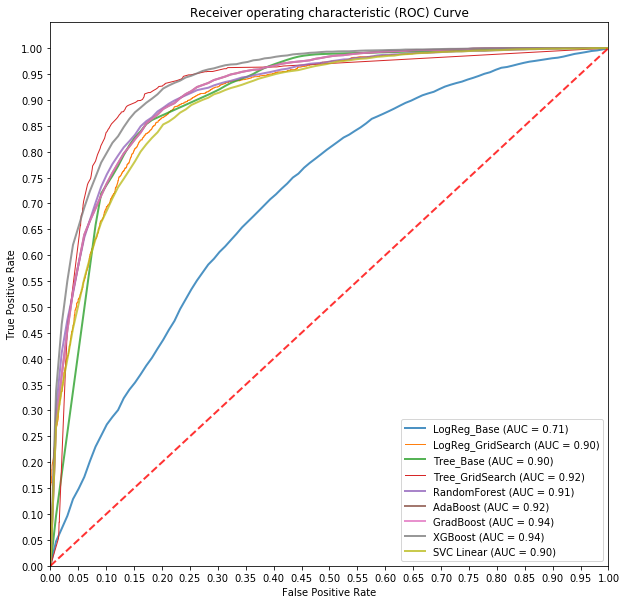

In [213]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(mean_fpr_LogReg_Base, mean_tpr_LogReg_Base,
        label=r'LogReg_Base (AUC = %0.2f)' % (mean_auc_LogReg_Base),
        lw=2, alpha=.8)
plot_roc_curve(logreg_grid_search, X_val, y_val,
                         name='LogReg_GridSearch',
                         lw=1, ax=ax)
ax.plot(mean_fpr_tree_clf_base, mean_tpr_tree_clf_base,
        label=r'Tree_Base (AUC = %0.2f)' % (mean_auc_tree_clf_base),
        lw=2, alpha=.8)
plot_roc_curve(tree_grid_search_2, X_val2, y_val2,
                         name='Tree_GridSearch',
                         lw=1, ax=ax)
ax.plot(mean_fpr_forest_base, mean_tpr_forest_base,
        label=r'RandomForest (AUC = %0.2f)' % (mean_auc_forest_base),
        lw=2, alpha=.8)
ax.plot(mean_fpr_adaboost_base, mean_tpr_adaboost_base,
        label=r'AdaBoost (AUC = %0.2f)' % (mean_auc_adaboost_base),
        lw=2, alpha=.8)
ax.plot(mean_fpr_gradboost_base, mean_tpr_adaboost_base,
        label=r'GradBoost (AUC = %0.2f)' % (mean_auc_gradboost_base),
        lw=2, alpha=.8)
ax.plot(mean_fpr_xgb_base, mean_tpr_xgb_base,
        label=r'XGBoost (AUC = %0.2f)' % (mean_auc_xgb_base),
        lw=2, alpha=.8)
ax.plot(mean_fpr_svc_base, mean_tpr_svc_base,
        label=r'SVC Linear (AUC = %0.2f)' % (mean_auc_svc_base),
        lw=2, alpha=.8)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_title('Receiver operating characteristic (ROC) Curve')
ax.legend(loc='lower right')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

<font size="4">The best models based on AUC are the **GradBoost** and **XGBoost** models. So we will apply one of them to the final test data to verify whether the model is generalisable:<font/>

In [161]:
X_train_over, y_train_over = smote.fit_sample(X_train2, y_train2) 
lf = gradboost_clf.fit(X_train_over, y_train_over)

In [173]:
for datasets in [('Validation_set', [X_val2, y_val2]), ('Test_set', [X_test2, y_test2])]:
    print(datasets[0], 'Accuracy:', lf.score(datasets[1][0], datasets[1][1]))

validation_set Accuracy: 0.8804006758387641
test_set Accuracy: 0.878083812098682


In [172]:
for datasets in [('Validation_set', [X_val2, y_val2]), ('Test_set', [X_test2, y_test2])]:
    
    fpr, tpr, threshold = roc_curve(datasets[1][1], lf.predict_proba(datasets[1][0])[:,1])
    print(datasets[0], 'AUC:', auc(fpr, tpr))

validation_set AUC: 0.940079854541791
test_set AUC: 0.9430778682633922


<font size="4">The **GradBoost** model has achieved the same AUC as it did during training stage and therfore we can assume that it is generalisable<font/>

In [131]:
X_train_over, y_train_over = smote.fit_sample(X_train2, y_train2) 
forest.fit(X_train_over, y_train_over)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [132]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [133]:
feature_names = [col.strip() for col in X_train_over.iloc[:,indices].columns]

In [215]:
# # Print the feature ranking
# print("Feature ranking:")


# # Plot the feature importances of the forest
# plt.figure(figsize = (15, 8))
# plt.title("Feature importances")
# plt.barh(range(10), importances[indices][:10],
#        color="r", align="center")
# plt.yticks(range(10), feature_names)
# plt.ylim([-1, 10])
# plt.gca().invert_yaxis()
# plt.show()

In [135]:
X_train_over, y_train_over = smote.fit_sample(X_train2, y_train2) 
gradboost_clf.fit(X_train_over, y_train_over)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [136]:
importances = gradboost_clf.feature_importances_
indices = np.argsort(importances)[::-1]

In [137]:
feature_names = [col.strip() for col in X_train_over.iloc[:,indices].columns]

In [216]:
# # Print the feature ranking
# print("Feature ranking:")


# # Plot the feature importances of the forest
# plt.figure(figsize = (15, 8))
# plt.title("Feature importances")
# plt.barh(range(10), importances[indices][:10],
#        color="r", align="center")
# plt.yticks(range(10), feature_names)
# plt.ylim([-1, 10])
# plt.gca().invert_yaxis()
# plt.show()

In [139]:
X_train_over, y_train_over = smote.fit_sample(X_train2, y_train2) 
xgb_clf.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [140]:
importances = xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1]

In [141]:
feature_names = [col.strip() for col in X_train_over.iloc[:,indices].columns]

In [217]:
# # Print the feature ranking
# print("Feature ranking:")


# # Plot the feature importances of the forest
# plt.figure(figsize = (15, 8))
# plt.title("Feature importances")
# plt.barh(range(10), importances[indices][:10],
#        color="r", align="center")
# plt.yticks(range(10), feature_names)
# plt.ylim([-1, 10])
# plt.gca().invert_yaxis()
# plt.show()

In [143]:
mean_forest_score = forest.score(X_train2, y_train)

In [144]:
mean_forest_score

0.8461538461538461

In [145]:
l = []
for i, estim in enumerate(forest.estimators_):
    l.append(abs(mean_forest_score - estim.score(X_train2, y_train)))

In [146]:
np.argmin(l)

19

In [147]:
dot_data = export_graphviz(forest.estimators_[np.argmin(l)], out_file=None, 
                           feature_names=X_train2.columns,  
                           class_names=np.unique(y_train2).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

In [148]:
graph = graph_from_dot_data(dot_data) 

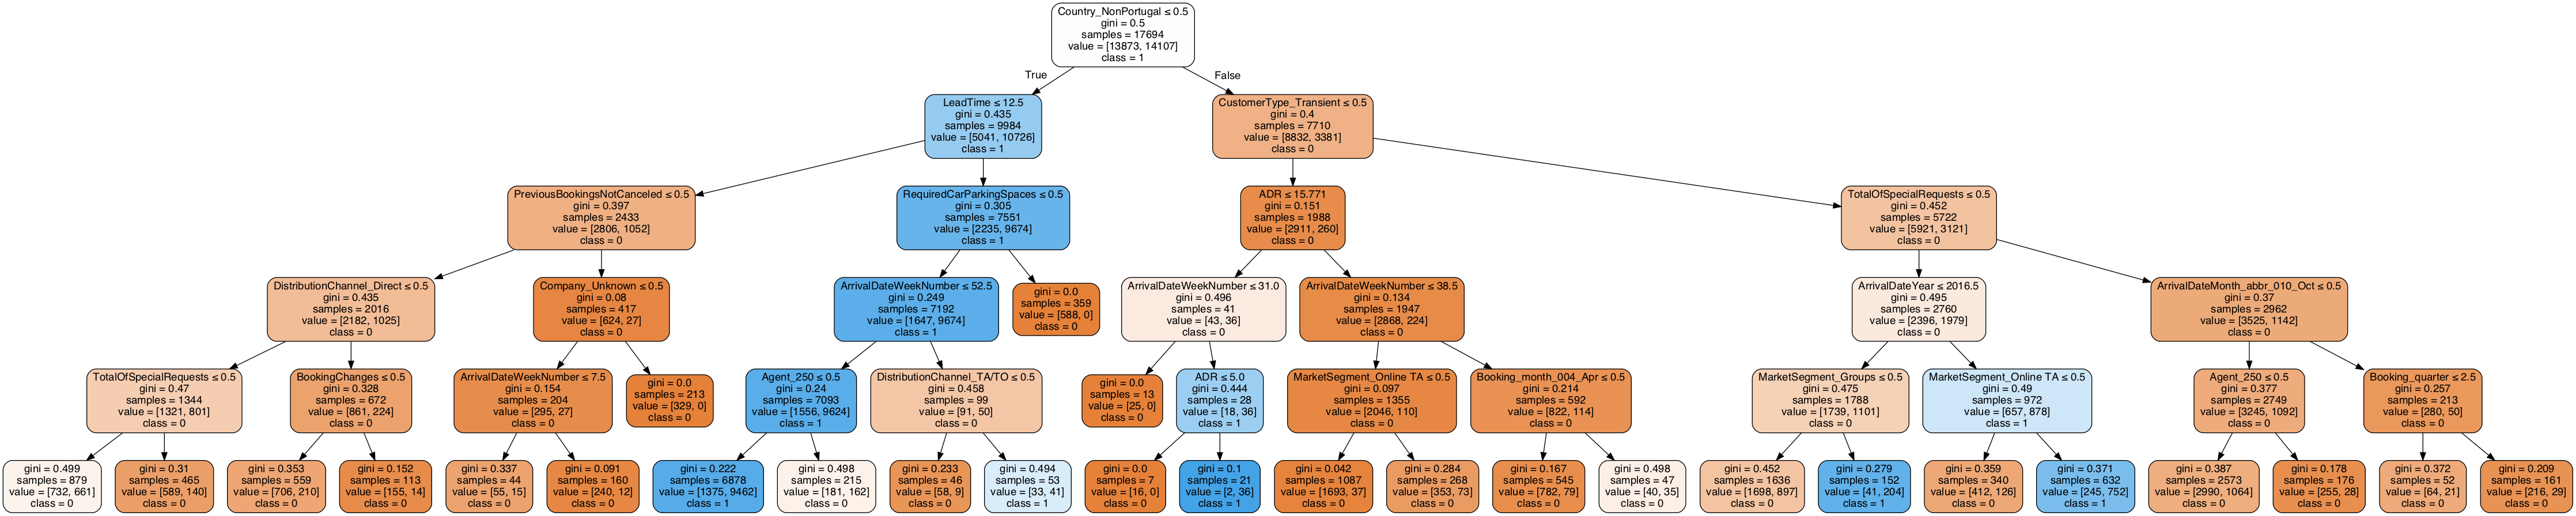

In [149]:
Image(graph.create_png())

In [150]:
dot_data = export_graphviz(tree_clf, out_file=None, 
                           feature_names=X_train2.columns,  
                           class_names=np.unique(y_train2).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

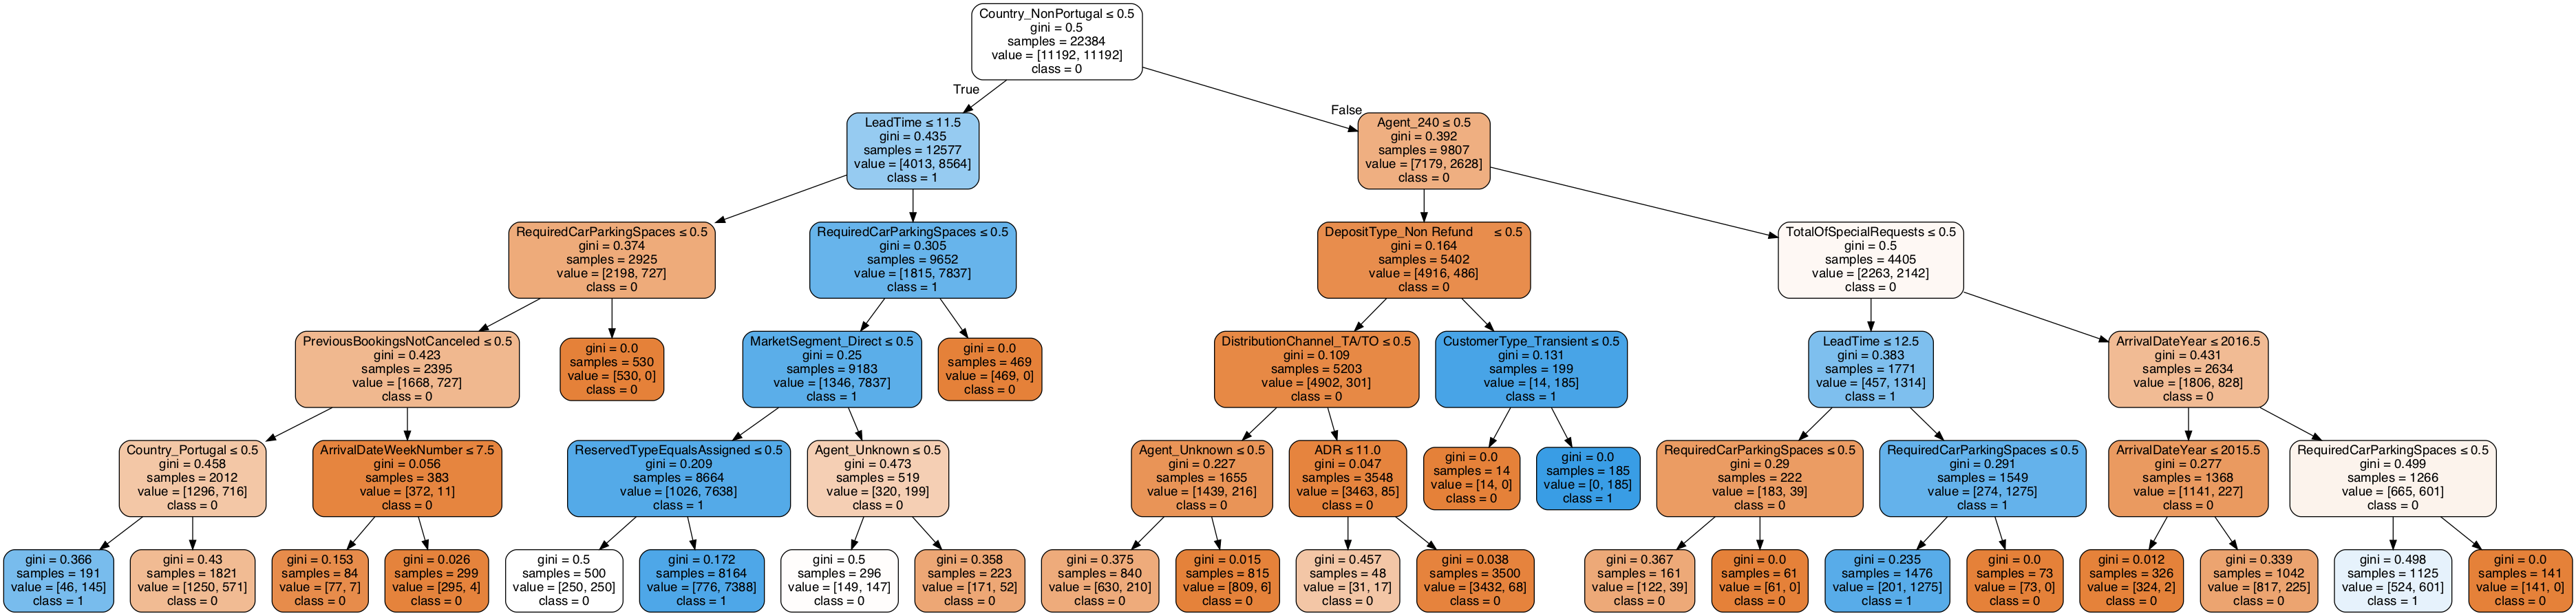

In [151]:
graph = graph_from_dot_data(dot_data) 
Image(graph.create_png())